In [1]:
%matplotlib inline
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

### Load all data into single dataframe
If we look at the data closely, we will find that the data is already divided into segments of 3 seconds with overlap of 1.5 seconds. So, there is a separation (empty row) between each segment. This means those separations get deleted if we simply remove all rows where accelerometer data is missing. So, we need to consider the case where both timestamp and accelerometer data are missing (this is the separation and should not be deleted as it will be useful in future).

Further, since the sampling rate of accelerometer is not constant, the number of samples in each segment is different. So, this needs to be handled in some way.

In [108]:
all_data_list = list()
for file in os.listdir('../data/annotated_csv/'):
    # check whether file to be loaded is csv 
    # and also ensure no other files are attempted to be parsed.
    if file[-4 : ] == '.csv':
        df = pd.read_csv(os.path.join('../data/annotated_csv/', file), names = ['time','Control','High_level','Expectation','Activity','linear_acc.x','linear_acc.y','linear_acc.z','gyro.z','gyro.x','gyro.y','ci','distance','proximity'], skiprows = [0])
        all_data_list.append(df)
        
# Combine all the dataframes
all_data_df = pd.concat(all_data_list)
# Drop unnecessary data
all_data_df.drop(['ci', 'distance', 'Control', 'Expectation', 'Activity', 'proximity', 'gyro.x', 'gyro.y', 'gyro.z'], axis = 1, inplace = True)
print(len(all_data_df)) 

# Due to combination of multiple dataframes, the indices remained the same from the original dataframe
# even in the full all_data_df dataframe. So, the indices needed to be reset. Upon resetting the indices
# get converted into a column called 'index', so it needs to removed as it is unnecessary. 
all_data_df.reset_index(inplace = True)
print(all_data_df.head())
all_data_df.drop('index', axis = 1, inplace = True)

# Indices are again reset so we can have a column of the correct indices which are required to 
# eliminate the unnecessary rows (which contained CI and proximity data only and no accelerometer data)
all_data_df.reset_index(inplace = True)
all_data_df.to_csv('../data/cleaned2.csv', index = None)

212755
   index      time High_level  linear_acc.x  linear_acc.y  linear_acc.z
0      0  0.000000    Dodging         345.0       -2701.0        -466.0
1      1  0.000000    Dodging         345.0       -2701.0        -466.0
2      2  0.021687    Dodging         442.0       -2287.0        -965.0
3      3  0.040944    Dodging         676.0       -1968.0       -1323.0
4      4  0.061339    Dodging        1406.0       -1561.0       -1228.0


### Discard rows that don't have accelerometer data (but not rows which indicate change of segment)

In [109]:
# Creating a list of indices where timestamp is not NaN but accelerometer data is NaN 
# i.e. indices which don't have any accelerometer data
drop_indices = list()
for t, x, ind in zip(all_data_df.iloc[:, 1], all_data_df.iloc[:, 3], all_data_df.iloc[:, 0]):
    if (pd.isna(x) and (not pd.isna(t))):
        drop_indices.append(ind)
        
# Then, drop those indices and drop the 'index' column created earlier since it is not needed now.
all_data_df.drop(all_data_df.index[drop_indices], inplace = True)
all_data_df.drop('index', axis = 1, inplace = True)
# saving to file for further use
all_data_df.to_csv('../data/cleaned3.csv', index = None)

In [20]:
df = pd.read_csv('../data/cleaned3.csv', names = ['time', 'High_level', 'linear_acc.x', 'linear_acc.y', 'linear_acc.z'], header = 0)

# labels = pd.DataFrame(pd.get_dummies(df['High_level'], prefix = 'label_'))
# print(labels.head())
# labels.to_csv('../data/labels.csv', index = None)

# drop the timestamps as they are not required since we already know the separation between examples
df.drop(['time'], axis = 1, inplace = True)

# normalizing acceleration data using factor of 16384 mentioned in datasheet of MPU6050
# to get the acceleration in multiples of 'g' (9.8 m/s^2)
df['linear_acc.x'] = df['linear_acc.x'] / 16384.0
df['linear_acc.y'] = df['linear_acc.y'] / 16384.0
df['linear_acc.z'] = df['linear_acc.z'] / 16384.0
print(df.head())
df.to_csv('../data/acc_only.csv', index = None, header = None)

  High_level  linear_acc.x  linear_acc.y  linear_acc.z
0    Dodging      0.021057     -0.164856     -0.028442
1    Dodging      0.021057     -0.164856     -0.028442
2    Dodging      0.026978     -0.139587     -0.058899
3    Dodging      0.041260     -0.120117     -0.080750
4    Dodging      0.085815     -0.095276     -0.074951


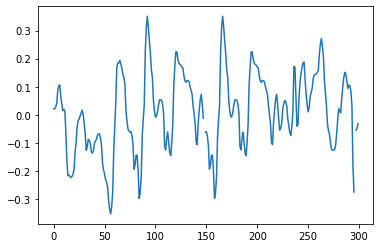

In [15]:
plt.plot(df['linear_acc.x'][ : 300])